<a href="https://colab.research.google.com/github/AndresPautrat/DataMining/blob/main/PC2_ReglasAsociacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Andres Pautrat
https://colab.research.google.com/drive/1MEphdJTv7m4E2E94LAnY1xo0eYP43Rka?usp=sharing


In [ ]:
#i think it a long tim but it work, i import the data localy to dont waste time
%%bash
products = drive.google.com/uc?id=1jTLkPSHs3se5Nco8SVijO0Yl_wVf4JuB
order_products = drive.google.com/uc?id=1gWgn4GoP8HpaItQqKXiVqrlUCw80yUcX

gdown --id 1jTLkPSHs3se5Nco8SVijO0Yl_wVf4JuB
gdown --id 1gWgn4GoP8HpaItQqKXiVqrlUCw80yUcX
unzip products.csv.zip
unzip order_products__prior.csv.zip


Archive:  products.csv.zip


bash: line 1: products: command not found
bash: line 2: order_products: command not found
Downloading...
From: https://drive.google.com/uc?id=1jTLkPSHs3se5Nco8SVijO0Yl_wVf4JuB
To: /content/products.csv.zip
100%|##########| 814k/814k [00:00<00:00, 52.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gWgn4GoP8HpaItQqKXiVqrlUCw80yUcX
To: /content/order_products__prior.csv.zip
165MB [00:00, 230MB/s]
replace products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [unzip ord]
replace products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [er_produc]
replace products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ts__prior]
replace products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [.csv.zip]
replace products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


First she import every necesary library.

In [ ]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

With this function she get the size of a file, but its only used to inform the user, with prints/

In [ ]:
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

Here she read the file, show it size and the first values in the dataframe.

In [ ]:
orders = pd.read_csv('order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (70024, 4);   size: 2.24 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1.0
1,2,28985,2,1.0
2,2,9327,3,0.0
3,2,45918,4,1.0
4,2,30035,5,0.0


She convert the dataframe to a series to use it in her algorithms.

In [ ]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

Here she review the propierties for te new serie

In [ ]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (7834978,);   size: 125.36 MB;   unique_orders: 776845;   unique_items: 47854


She declare all the functions she need for her association rules function.

In [ ]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns] 

Here she declare her main function where she get a dataset and a percentage for minimun suport and find the differente association rules.

In [ ]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [ ]:
rules = association_rules(orders, 0.1)  

Starting order_item:                7834978
Items with support >= 0.1:            1771
Remaining order_item:               5006590
Remaining orders with 2+ items:      660252
Remaining order_item:               4928270
Item pairs:                         2246233
Item pairs with support >= 0.1:       1547



Here she use que association rules she have found before with the dataset of products to get the values where the rules can be applied.

In [ ]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Nonfat Icelandic Style Strawberry Yogurt,672,0.101779,4651,0.704428,2548,0.385913,0.144485,0.263736,0.374398
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,917,0.138886,4651,0.704428,3991,0.604466,0.197162,0.229767,0.326175
5,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,871,0.131919,3991,0.604466,4651,0.704428,0.218241,0.187272,0.309813
6,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,843,0.127679,4335,0.656567,4651,0.704428,0.194464,0.181251,0.276059
3,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,772,0.116925,4651,0.704428,4335,0.656567,0.165986,0.178085,0.252808
...,...,...,...,...,...,...,...,...,...,...,...
30,Organic Small Bunch Celery,Banana,742,0.112381,16276,2.465119,112681,17.066363,0.045589,0.006585,0.002671
31,Organic Yellow Onion,Banana,1227,0.185838,27135,4.109794,112681,17.066363,0.045218,0.010889,0.002650
37,Organic Cucumber,Banana,848,0.128436,19355,2.931456,112681,17.066363,0.043813,0.007526,0.002567
515,Cucumber Kirby,Bag of Organic Bananas,782,0.118440,23427,3.548191,89921,13.619194,0.033380,0.008697,0.002451


Merge pattern can be mined, to do it we need use subsets of the data and apply a eclat funcion to get the frequency of the values that have a higher support than the minimum support, then you compare the diferent frequency of the subdatasets, to find patterns. You can see the results with plots lines of the different subsets.

Sky pattern can be applied, for that we need to find the values that highlight. This can be easy noticed with plot points. With code we need to compare the values, frequency, confidence and lift then see in the data if a values have higher values than the others or with a convinacion of features.

In [ ]:
#at least i try :'c
%%script bash
curl -O https://borgelt.net/bin/py3/fim.so
sudo ln -sf "$(pwd)/fim.so" /usr/local/lib/python3.6/dist-packages/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756k  100  756k    0     0   585k      0  0:00:01  0:00:01 --:--:--  585k


In [ ]:
from fim import *
import matplotlib.pyplot as plt
import numpy as no
import seaborn as sns; sns.set()
import time
import pandas as pd

In [ ]:
def emergingPattern(d, d1, minsupp, mingr):
    allitemsets = eclat(d, target='a', supp=-minsupp)
    if len(allitemsets) > 0:
        allitemsets1 = eclat(d1, target='a', supp=-minsupp)
        df = pd.DataFrame(allitemsets)
        df.columns = ["Pattern", "Freq"]
        df1 = pd.DataFrame(allitemsets1)
        df1.columns = ["Pattern", "Freq1"]
        emerging = df.join(df1.set_index('Pattern'), on='Pattern').fillna(0)
        emerging["Gr"] = ((len(d) - len(d1)) * emerging["Freq1"]) / \
                          (len(d1) * (emerging["Freq"] - emerging["Freq1"]))
        emerging = emerging[emerging.Gr >= mingr]
        jep = emerging[emerging.Freq == emerging.Freq1]
        
        return emerging, jep, True
    
    return _, _, False

In [ ]:
def plotEmergingPatterns(v, em):
    numberData = []
    if v:
        for i in range(0, 61, 5):
            em_ = em[em.Gr >= i]
            numberData.append((i, len(em_), 0))
    df = pd.DataFrame(numberData)
    df.columns = ["Growth-rate", "#Itemsets", "TimeEmergingItemsets"]
    sns.lineplot(x="Growth-rate", y="#Itemsets", data=df)

    return df


,Growth-rate,#Itemsets,TimeEmergingItemsets
0,0,0,0
1,5,0,0
2,10,0,0
3,15,0,0
4,20,0,0
5,25,0,0
6,30,0,0
7,35,0,0
8,40,0,0
9,45,0,0


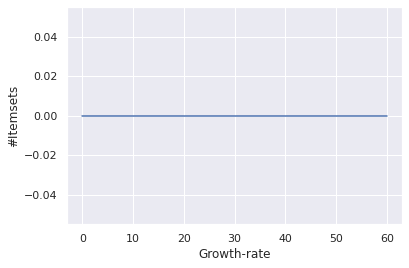

In [ ]:
em, jep, ok = emergingPattern(item_name, item_name, -1, 1)
plotEmergingPatterns(ok, em)